In [14]:
import yaml
import torch

from roadvision3d.src.engine.model_builder import build_model
from roadvision3d.src.engine.model_saver import load_checkpoint
from PIL import Image
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def inference(img, calib, model):

    return None



In [15]:
config_path = '/home/javier/pytorch/RoadVision3D/roadvision3d/configs/MonoLSS_DAIR_150e.yaml'
checkpoint_path = '/home/javier/pytorch/RoadVision3D/work_dirs/MonoLSS_DAIR_150e_valid/logs/checkpoints/checkpoint_epoch_150.pth'
cfg = yaml.load(open(config_path, 'r'), Loader=yaml.Loader)    
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

model = build_model(cfg)
load_checkpoint(model = model,
                optimizer = None,
                filename = checkpoint_path,
                map_location=device)


150

In [28]:
data_id = 0

img_path = '/home/javier/datasets/DAIR-V2X/single-infrastructure-side/image/000000.jpg'
calib_camera_path = '/home/javier/datasets/DAIR-V2X/single-infrastructure-side/calib/camera_intrinsic/000000.json'
calib_lidar_path = '/home/javier/datasets/DAIR-V2X/single-infrastructure-side/calib/virtuallidar_to_camera/000000.json'

In [36]:
from roadvision3d.src.datasets.object_3d import get_affine_transform

def process_image(img_path, cfg):
    raw_img = Image.open(img_path)
    img_size = np.array(raw_img.size)

    img_resolution = np.array(cfg['dataset']['resolution'])
    # statistics
    mean = np.array(cfg['dataset']['mean'], dtype=np.float32)
    std  = np.array(cfg['dataset']['std'], dtype=np.float32)

    center = np.array(img_size) / 2
    crop_size = img_size

    trans, trans_inv = get_affine_transform(center, crop_size, 0, img_resolution, inv=1)

    img_rescaled = raw_img.transform(tuple(img_resolution.tolist()),
                            method=Image.AFFINE,
                            data=tuple(trans_inv.reshape(-1).tolist()),
                            resample=Image.BILINEAR)

    # image encoding
    img = np.array(img_rescaled).astype(np.float32) / 255.0
    img = (img - mean) / std
    img = img.transpose(2, 0, 1)  # C * H * W

    img_tensor = torch.from_numpy(img)

    # Ensure the tensor is of the correct dtype (float32) and device (CPU or CUDA)
    img_tensor = img_tensor.float()  # Ensures tensor is in float32, if not already

    coord_range = torch.from_numpy(np.array([center-crop_size/2,center+crop_size/2]).astype(np.float32)).float()


    return img_tensor, coord_range

img_tensor, coord_range = process_image(img_path, cfg)
    
print(coord_range)
print(img_tensor.shape)


tensor([[   0.,    0.],
        [1920., 1080.]])
torch.Size([3, 1088, 1920])


In [37]:
from roadvision3d.src.datasets.object_3d import Calibration
# Load and process the calib
calib = Calibration.from_dair_calib_file(calib_camera_path, calib_lidar_path)
calib_tensor = torch.from_numpy(calib.P2).float()

In [38]:
img_tensor = img_tensor.unsqueeze(0).to(device)
calib_tensor = calib_tensor.unsqueeze(0).to(device)
coord_ranges_tensor = coord_range.unsqueeze(0).to(device)

model = model.to(device)

info = {
    'calibs': [calib],
    'img_id': torch.tensor([data_id]),  # Image ID as a tensor with batch dimension
    'img_size': torch.tensor([cfg['dataset']['resolution']]),  # Image size with batch dimension
    'bbox_downsample_ratio': torch.tensor([[4, 4]])  # Downsample ratio with batch dimension
}

print(img_tensor.shape)

dets = model(img_tensor, calib_tensor, coord_ranges=coord_ranges_tensor, mode='test', info=info)


torch.Size([1, 3, 1088, 1920])


In [56]:
print(dets.keys())
keys = list(dets.keys())
first_key = keys[0]
print(type(first_key))
print(dets[first_key])

dict_keys([tensor(0)])
<class 'torch.Tensor'>
[[0, -1.2610782540498011, tensor(185.4341), tensor(748.5088), tensor(501.0609), tensor(1002.2876), 1.48823082447052, 1.988394021987915, 4.3001227378845215, -5.007819652557373, 3.000474452972412, 19.434873580932617, tensor(-1.5281), 0.392065], [0, -1.8234492997315268, tensor(1249.6599), tensor(594.6121), tensor(1481.7327), tensor(783.6268), 1.5394902229309082, 1.846142292022705, 4.276968002319336, 4.745306015014648, 1.795665979385376, 25.306882858276367, tensor(-1.6312), 0.36859298], [0, -1.5954575623061995, tensor(959.6093), tensor(399.5363), tensor(1067.7035), tensor(509.8182), 1.564476728439331, 1.8662365674972534, 4.254291534423828, 1.3264644145965576, -1.4124902486801147, 39.454280853271484, tensor(-1.5620), 0.4027668], [0, -1.7344493577864508, tensor(1139.3777), tensor(413.1039), tensor(1271.0688), tensor(523.6719), 1.476938009262085, 1.843721628189087, 4.251536846160889, 4.541141986846924, -1.2057926654815674, 38.519020080566406, tens

In [61]:
from roadvision3d.src.datasets.object_3d import Object3d
def result_to_object3d(dets):
    results = []
    for det in dets:
         # Extract each value
        cls_type = det[0]   # class type
        truncation = 0.0
        occlusion = 0.0             
        alpha = det[1]                   # alpha
        bbox2d = [
            float(det[2]),               # x1 (converted from tensor)
            float(det[3]),               # y1 (converted from tensor)
            float(det[4]),               # x2 (converted from tensor)
            float(det[5])                # y2 (converted from tensor)
        ]
        h = det[6]                       # height
        w = det[7]                       # width
        l = det[8]                       # length
        pos = [
            float(det[9]),               # x position
            float(det[10]),              # y position
            float(det[11])               # z position
        ]
        ry = float(det[12])              # rotation around y-axis (converted from tensor)
        score = det[13] if len(det) > 13 else None  # score (if exists)
        print(bbox2d)
        result = Object3d(cls_type, alpha, bbox2d, h, w, l, pos, ry, trucation=truncation, occlusion=occlusion, score=score)
        results.append(result)
    return results

results = result_to_object3d(dets[first_key])
print(results)

[185.43408203125, 748.5087890625, 501.0609130859375, 1002.28759765625]
[1249.659912109375, 594.612060546875, 1481.732666015625, 783.6268310546875]
[959.6092529296875, 399.53631591796875, 1067.7034912109375, 509.81817626953125]
[1139.377685546875, 413.1038818359375, 1271.06884765625, 523.671875]
[424.07220458984375, 213.09544372558594, 494.43035888671875, 268.0102233886719]
[943.6939697265625, 308.88995361328125, 1022.3189697265625, 386.6368408203125]
[800.6168823242188, 307.8736572265625, 887.2378540039062, 394.94989013671875]
[753.4841918945312, 401.8038330078125, 869.8330688476562, 520.16943359375]
[661.252197265625, 599.50341796875, 842.9415283203125, 788.1002197265625]
[1836.953369140625, 347.3174133300781, 1871.62890625, 433.2691955566406]
[285.07720947265625, 248.25112915039062, 387.29296875, 333.9107360839844]
[936.6589965820312, 700.19921875, 1148.6741943359375, 924.6673583984375]
[1738.2764892578125, 336.5355224609375, 1780.2608642578125, 422.8575439453125]
[84.41387939453125,

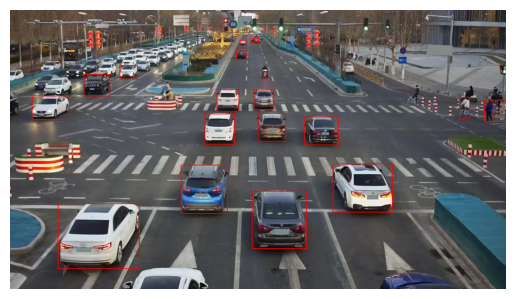

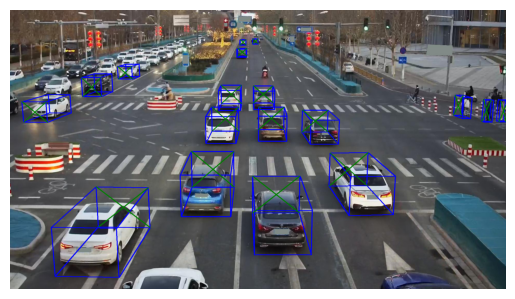

In [62]:
from roadvision3d.visualization import Visualizer
 
# the visualizer with calibration data and pitch
visualizer = Visualizer(calib=calib, pitch=0.22)

img_file = Image.open(img_path)

# Draw 2D bounding boxes on the image
image_with_2d = visualizer.draw_2d_bboxes(img_file, results, color='red', width=3, display=True)

# Draw 3D bounding boxes on the image
image_with_3d = visualizer.draw_3d_bboxes(img_file, results, color='blue', color_front='green', width=4, display=True)